<a href="https://colab.research.google.com/github/luis8choa/Computer_Vision/blob/main/Cifar10_keras_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPooling2D
from tensorflow import keras
#from keras.utils import np_utils
from keras.datasets import cifar10
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2

In [2]:
pip install -q -U keras-tuner

In [3]:
import keras_tuner as kt

Using TensorFlow backend


In [4]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

In [5]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


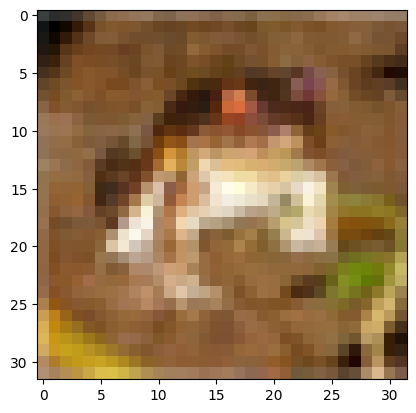

In [6]:
plt.figure()
plt.imshow(x_train[0,:,:],'gray')

In [7]:
print(np.max(x_train[0]))

255


In [8]:
x_train = x_train / 255
x_test = x_test / 255

"""
# one hot encode outputs
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)
num_classes = y_test.shape[1]
num_classes
"""

'\n# one hot encode outputs\ny_train = tf.keras.utils.to_categorical(y_train)\ny_test = tf.keras.utils.to_categorical(y_test)\nnum_classes = y_test.shape[1]\nnum_classes\n'

In [9]:
print(x_train.shape)
print(y_train.shape)

(50000, 32, 32, 3)
(50000, 1)


In [10]:
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(32, 32,3)))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(keras.layers.Dense(units=hp_units, activation='softmax'))
  model.add(keras.layers.Dense(10))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

In [11]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='keras_tuner')

Reloading Tuner from my_dir/keras_tuner/tuner0.json


In [12]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [13]:
tuner.search(x_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 26 Complete [00h 00m 53s]
val_accuracy: 0.44940000772476196

Best val_accuracy So Far: 0.48649999499320984
Total elapsed time: 00h 17m 58s

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 512 and the optimal learning rate for the optimizer
is 0.0001.



In [15]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, epochs=50, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
1250/1250 [==============================] - 5s 4ms/step - loss: 1.8658 - accuracy: 0.3372 - val_loss: 1.7530 - val_accuracy: 0.3873
Epoch 2/50
1250/1250 [==============================] - 5s 4ms/step - loss: 1.6947 - accuracy: 0.4054 - val_loss: 1.6653 - val_accuracy: 0.4183
Epoch 3/50
1250/1250 [==============================] - 4s 3ms/step - loss: 1.6211 - accuracy: 0.4280 - val_loss: 1.6890 - val_accuracy: 0.4078
Epoch 4/50
1250/1250 [==============================] - 5s 4ms/step - loss: 1.5697 - accuracy: 0.4476 - val_loss: 1.6917 - val_accuracy: 0.3945
Epoch 5/50
1250/1250 [==============================] - 4s 3ms/step - loss: 1.5279 - accuracy: 0.4630 - val_loss: 1.5971 - val_accuracy: 0.4393
Epoch 6/50
1250/1250 [==============================] - 4s 3ms/step - loss: 1.4911 - accuracy: 0.4776 - val_loss: 1.5636 - val_accuracy: 0.4557
Epoch 7/50
1250/1250 [==============================] - 5s 4ms/step - loss: 1.4648 - accuracy: 0.4878 - val_loss: 1.5518 - val_accuracy:

In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(img_train, label_train, epochs=best_epoch, validation_split=0.2)

In [ ]:
eval_result = hypermodel.evaluate(img_test, label_test)
print("[test loss, test accuracy]:", eval_result)

In [ ]:
def model():
    # create model
    input_shape = (32, 32,3) #capas 64,80,80  ,512.  , 0.4 , batch=32 / 50,60,60  ,400.  , 0.5 , batch=32
    model = Sequential()
    model.add(Conv2D(64, (3, 3), input_shape=(input_shape),padding='valid', strides=(1,1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
    model.add(Conv2D(80, (3, 3),padding='valid', strides=(1,1) ,activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2) ,strides=(2,2)))
    model.add(Conv2D(80, (3, 3),padding='valid', strides=(1,1) ,activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 80)        46160     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 80)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 80)          57680     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 80)          0         
_________________________________________________________________
dropout (Dropout)            (None, 2, 2, 80)          0

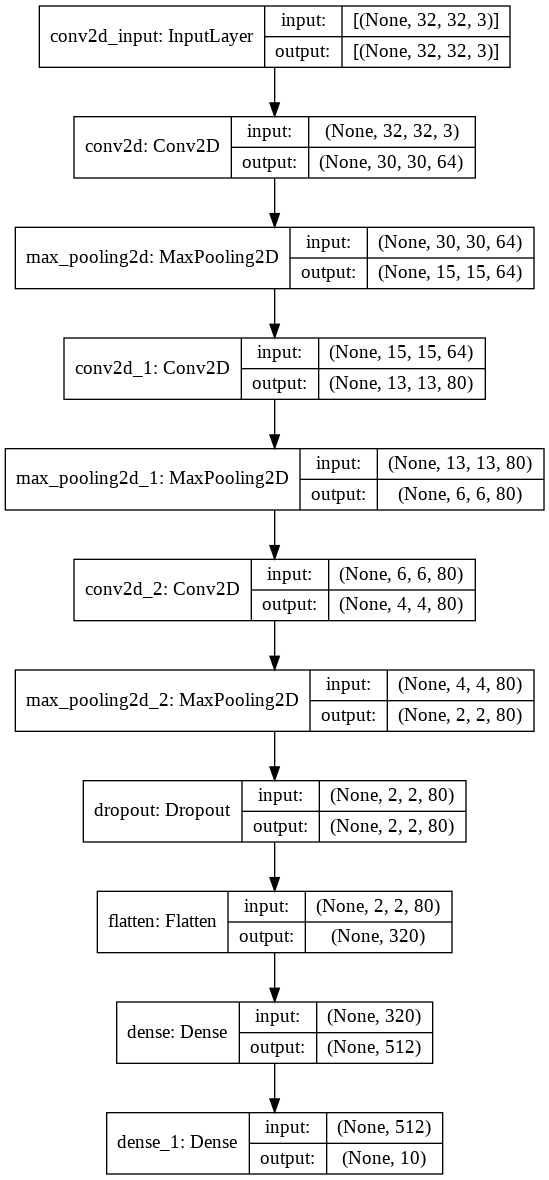

In [ ]:
model = model()
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
print(x_train.shape)
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=40, batch_size=32, verbose=1, shuffle=True)

(50000, 32, 32, 3)
Epoch 1/40
1563/1563 [==============================] - 47s 10ms/step - loss: 1.6265 - accuracy: 0.3996 - val_loss: 1.3032 - val_accuracy: 0.5306
Epoch 2/40
1563/1563 [==============================] - 15s 9ms/step - loss: 1.2964 - accuracy: 0.5300 - val_loss: 1.1584 - val_accuracy: 0.5831
Epoch 3/40
1563/1563 [==============================] - 15s 9ms/step - loss: 1.1604 - accuracy: 0.5828 - val_loss: 1.0601 - val_accuracy: 0.6204
Epoch 4/40
1563/1563 [==============================] - 15s 10ms/step - loss: 1.0758 - accuracy: 0.6162 - val_loss: 0.9544 - val_accuracy: 0.6700
Epoch 5/40
1563/1563 [==============================] - 15s 10ms/step - loss: 1.0140 - accuracy: 0.6389 - val_loss: 0.9174 - val_accuracy: 0.6789
Epoch 6/40
1563/1563 [==============================] - 14s 9ms/step - loss: 0.9757 - accuracy: 0.6515 - val_loss: 0.8670 - val_accuracy: 0.7025
Epoch 7/40
1563/1563 [==============================] - 15s 10ms/step - loss: 0.9364 - accuracy: 0.6675 - va

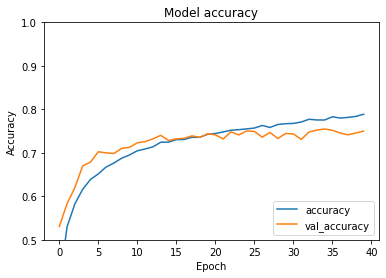

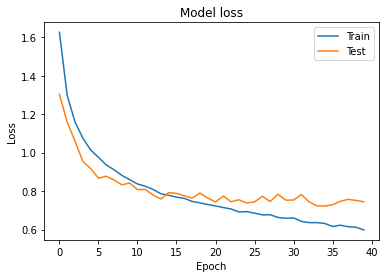

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()